In [1]:
import numpy as np
import time
import motors

import cv2
from ultralytics import YOLO
from IPython.display import display, clear_output
import IPython.display as display_utils
import pyzed.sl as sl
import math
from PIL import Image

In [2]:
# TODO: Check for and set the actual parameters for the camera device.
cam_hfov = 101
cam_vfov = 68
cam_width = 720
cam_height = 480

In [3]:
# Load YOLOv8 pose model
model = YOLO("yolov8n-pose.pt")

# Open webcam
cap = cv2.VideoCapture(0)

# Set configuration parameters
init_params = sl.InitParameters()
init_params.depth_mode = sl.DEPTH_MODE.ULTRA # Use ULTRA depth mode
init_params.coordinate_units = sl.UNIT.MILLIMETER # Use millimeter units (for depth measurements)

In [4]:
def pixel_to_angle(x, y, width=cam_width, height=cam_height, hfov=cam_hfov, vfov=cam_vfov):
    """
    Calculate horizontal, vertical, and Euclidean viewing angles for a given pixel.

    Parameters:
        x (float): Pixel x-coordinate
        y (float): Pixel y-coordinate
        width (int): Image width in pixels
        height (int): Image height in pixels
        hfov (float): Horizontal field of view in degrees
        vfov (float): Vertical field of view in degrees

    Returns:
        (h_angle, v_angle, euclidean_angle): Tuple of three angles in degrees
    """
    cx, cy = width / 2, height / 2

    h_angle = ((x - cx) / cx) * (hfov / 2)
    v_angle = ((y - cy) / cy) * (vfov / 2)

    euclidean_angle = math.sqrt(h_angle**2 + v_angle**2)

    if x < cx:
        euclidean_angle = -euclidean_angle

    return h_angle, v_angle, euclidean_angle

In [5]:
def get_ankles_angles(frame, pose_results):
    keypoints = pose_results[0].keypoints.xy.cpu().numpy()

    image = sl.Mat()
    depth_map = sl.Mat()
    runtime_parameters = sl.RuntimeParameters()

    zed = sl.Camera()
    
    if zed.grab(runtime_parameters) == sl.ERROR_CODE.SUCCESS :
      # A new image and depth is available if grab() returns SUCCESS
      zed.retrieve_image(image, sl.VIEW.LEFT) # Retrieve left image
      zed.retrieve_measure(depth_map, sl.MEASURE.DEPTH) # Retrieve depth

    euclidean_angles = []
    
    for idx, person_keypoints in enumerate(keypoints):
        if len(person_keypoints) < 17:
            continue
        left_foot = person_keypoints[15]  # left ankle
        right_foot = person_keypoints[16] # right ankle

        lx, ly = map(int, left_foot)
        rx, ry = map(int, right_foot)

        # print(f"Person {idx}: Left foot ({lx},{ly}), Right foot ({rx},{ry})")

        cv2.circle(annotated, (lx, ly), 5, (0, 255, 0), -1)
        cv2.circle(annotated, (rx, ry), 5, (0, 0, 255), -1)

        l_ankle_depth = depth_map.get_value(lx, ly)
        r_ankle_depth = depth_map.get_value(rx, ry)

        # print(f"Person {idx}: Left foot depth ({l_ankle_depth}), Right foot depth ({r_ankle_depth})")

        l_h_angle, l_v_angle, l_euclidean_angle = pixel_to_angle(x=lx, y=ly)
        r_h_angle, r_v_angle, r_euclidean_angle = pixel_to_angle(x=rx, y=ry)

        # print("Left foot angle: {:.2f} degrees".format(l_euclidean_angle))
        # print("Right foot angle: {:.2f} degrees".format(r_euclidean_angle))
        angle_mean = (l_euclidean_angle + r_euclidean_angle) / 2

        euclidean_angles.append(angle_mean)

    return euclidean_angles

In [6]:
class SpringFollower:
    def __init__(self, speed=0.5, k=10.0, b=6.0, rest_length=0.5, dt=0.02):
        self.speed = speed
        self.motors = motors.MotorsYukon(mecanum=False)
                                         
        self.k = k
        self.b = b
        self.l0 = rest_length
        self.dt = dt

        self.vel = np.array([0.0, 0.0])
        self._origin = np.array([0.0, 0.0])

    def human_position(self, r, theta):
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        return np.array([x, y])

    def update(self, human_position):
        distance = human_position[0]
        angle = human_position[1]
        
        ph = self.human_position(human_position[0], human_position[1])
        diff = ph - self._origin
        dist = np.linalg.norm(diff)

        if dist > 1e-6:
            vel_spring = (self.k / self.b) * (1 - self.l0 / dist) * diff
        else:
            vel_spring = np.zeros(2)

        self.vel = vel_spring / self.b
        return self.vel

    def drive(self, angle):
        # max angle is 90 degrees
        # at -90 and 90 degrees wheel multiplier should be 0 for corresponding side
        # as robot is turning theta decreeses
        temp = angle
        np.clip(temp, 1, 1)

        print("Angle in drive = ", angle)
        
        turning = 0.5*np.cos(angle)

        turning_speed = turning*self.speed
        print("Turning_speed = ", turning_speed)
        
        print("Turning: ", turning)
        if angle > 0:
            print("turning right")
            self.motors.frontLeft(speed=self.speed)
            self.motors.backLeft(speed=self.speed)

            self.motors.frontRight(speed=turning_speed)
            self.motors.backRight(speed=turning_speed)

            return True

        elif angle < 0:            
            print("turning left")

            self.motors.frontLeft(speed=turning_speed)
            self.motors.backLeft(speed=turning_speed)

            self.motors.frontRight(speed=self.speed)
            self.motors.backRight(speed=self.speed)

        else:
            self.motors.frontLeft(speed=self.speed)
            self.motors.backLeft(speed=self.speed)

            self.motors.frontRight(speed=self.speed)
            self.motors.backRight(speed=self.speed)

            return False


    """
    def move(self, vel):
        theta = np.angle(vel)

        self.drive(theta)
    """

    
    def move(self, angle):
        self.drive(angle)    
    
    
    def stop(self):
        # turn of cameras and such
        self.motors.stop()
            
        
        

In [7]:
follower = SpringFollower(speed=0.4)

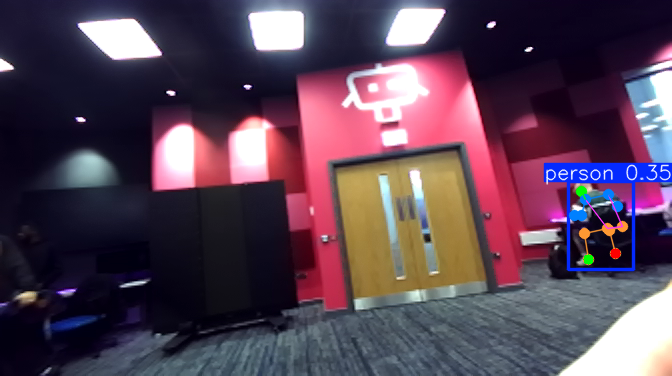

human_position =  [1, 0.5926667589390865]
Angle in drive =  0.5926667589390865
Turning_speed =  0.16589080909380952
Turning:  0.4147270227345238
turning right
Elapsed Time: 61.64282822608948 seconds
Control frequency =  3.244497466379272


In [8]:
import time

start_time = time.time()

frequency_count= 0

was_turning_right = True

for i in range(0, 200, 1):
    
    ok, frame = cap.read()
    if not ok:
        print("Not ok")
        break

    h, w, channels = frame.shape
    half = w//2

    # Only use the left half of the image.
    l_half_frame = frame[:, :half] 

    # Run pose detection
    results = model(l_half_frame, verbose=False)
    annotated = results[0].plot()

    angles = get_ankles_angles(l_half_frame, results)
    print("People ankles angles:", angles)
    
    # Convert BGR (OpenCV) -> RGB (for Jupyter display)
    annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(annotated_rgb)

    # Clear and update frame in notebook
    clear_output(wait=True)
    display_utils.display(img)
    # get sensor information

    #====================================================================================

    if len(angles) == 0:
        print("Lost contact")
        if was_turning_right:
            human_position = [1, math.radians(90)]
        else:
            human_position = [1, math.radians(-90)]
        
    else:
        human_position = [1, math.radians(angles[0])]
        print("human_position = ", human_position)
    #human_position = get_position() # vector of (distance, angle)
    
    # decide heading
    vel = follower.update(human_position) # vector of (vx, vy)
    
    # tell the motors
    was_turning_right = follower.drive(human_position[1])

    frequency_count+=1

follower.stop()
    
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time} seconds")

control_frequency = frequency_count/elapsed_time
print(f"Control frequency = ", control_frequency)

In [9]:
follower.stop()